# An Expected Danger model for Premier League soccer events. 

### for notebook Google Colab :
1. **Upload Data**:  upload them directly to the file sidebar.
2. **Install Requirements**

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

try:
    import google.colab
    !pip install pandas numpy scikit-learn matplotlib seaborn pyarrow
except:
    pass

import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression

%matplotlib inline
sns.set_theme(style="whitegrid")

## Data Preparation
Link passes to shots occurring within 15 seconds.

In [24]:
data_dir = os.getcwd()
event_dir = os.path.join(data_dir, "event_data")

pass_list = []
shot_list = []


files = [f for f in os.listdir(event_dir) if f.endswith('.json')]
print(f"Processing {len(files)} files...")

for filename in files:
    with open(os.path.join(event_dir, filename), 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    events = data.get('events', [])
    match_id = str(data.get('matchId', filename.replace('.json', '')))
    
    for e in events:
        ts = int(e.get('minute', 0)) * 60 + int(e.get('second', 0))
        e_type = e.get('type', {}).get('primary')
        
        if e_type == 'pass':
            p = e.get('pass')
            if p:
                pass_list.append({
                    'match_id': match_id,
                    'player_id': e.get('player', {}).get('id'),
                    'team_id': str(e.get('team', {}).get('id')),
                    'x': e.get('location', {}).get('x'),
                    'y': e.get('location', {}).get('y'),
                    'end_x': p.get('endLocation', {}).get('x'),
                    'end_y': p.get('endLocation', {}).get('y'),
                    'timestamp': ts
                })
        elif e_type == 'shot':
            s = e.get('shot')
            if s:
                shot_list.append({
                    'match_id': match_id,
                    'team_id': str(e.get('team', {}).get('id')),
                    'timestamp': ts,
                    'xg': s.get('xg', 0)
                })

passes_df = pd.DataFrame(pass_list).sort_values('timestamp')
shots_df = pd.DataFrame(shot_list).sort_values('timestamp')

merged = pd.merge_asof(
    passes_df,
    shots_df.rename(columns={'timestamp': 'shot_ts', 'xg': 'shot_xg'}),
    left_on='timestamp', right_on='shot_ts',
    by=['match_id', 'team_id'],
    direction='forward', tolerance=15
)

merged['has_shot'] = merged['shot_xg'].notna().astype(int)
merged['shot_xg'] = merged['shot_xg'].fillna(0)
print(f"Final Dataset: {len(merged)} passes.")

Processing 380 files...
Final Dataset: 320903 passes.


## Expected Danger Modeling
1. Fit Logistic Regression for $P(Shot)$.
2. Fit Linear Regression for $P(Goal)$ via xG.
3. Combine for ED metric.

In [25]:
# Feature Eng
df = merged.copy()
df['start_x_sq'], df['start_y_sq'] = df['x']**2, df['y']**2
df['end_x_sq'], df['end_y_sq'] = df['end_x']**2, df['end_y']**2
df['dist_to_goal'] = np.sqrt((100 - df['end_x'])**2 + (50 - df['end_y'])**2)
df['angle_to_goal'] = np.abs(np.arctan2(50 - df['end_y'], 100 - df['end_x']))

features = ['x', 'y', 'end_x', 'end_y', 'start_x_sq', 'start_y_sq', 'dist_to_goal', 'angle_to_goal']
df_model = df.dropna(subset=features).copy()

# Model 1: P(Shot)
m1 = LogisticRegression(max_iter=2000).fit(df_model[features], df_model['has_shot'])
df_model['prob_shot'] = m1.predict_proba(df_model[features])[:, 1]

# Model 2: xG
shot_only = df_model[df_model['has_shot'] == 1]
m2 = LinearRegression().fit(shot_only[features], shot_only['shot_xg'])
df_model['pred_xg'] = m2.predict(df_model[features])

# Combine
df_model['expected_danger'] = (df_model['prob_shot'] * df_model['pred_xg']).clip(lower=0)

## Player Rankings
Rank players by ED per 90

In [26]:
players = pd.read_parquet('data_tables/players.parquet')
mins = pd.read_parquet('data_tables/minutes.parquet')

stats = df_model.groupby('player_id').agg({'expected_danger': 'sum', 'has_shot': 'sum'}).rename(columns={'has_shot': 'danger_passes'})
total_mins = mins.groupby('player_id')['minutes'].sum().reset_index()

final = stats.reset_index().merge(total_mins, on='player_id').merge(players[['player_id', 'short_name', 'role']], on='player_id')
final['ed_per_90'] = (final['expected_danger'] / final['minutes']) * 90
final['dp_per_90'] = (final['danger_passes'] / final['minutes']) * 90

print("Positional Top Performers (ED/90):")
relevant_roles = ['Forward', 'Midfielder', 'Defender']
for role in relevant_roles:
    print(f"\n--- Top 5 {role}s ---")
    pos_data = final[(final['role'] == role) & (final['minutes'] > 500)].sort_values('ed_per_90', ascending=False)
    display(pos_data[['short_name', 'ed_per_90']].head(5))


Positional Top Performers (ED/90):

--- Top 5 Forwards ---


,short_name,ed_per_90
383,J. Doku,0.789083
48,J. Grealish,0.775789
476,Savinho,0.656387
96,T. Werner,0.593527
350,B. Saka,0.585548



--- Top 5 Midfielders ---


,short_name,ed_per_90
71,K. De Bruyne,0.816598
81,M. Kovačić,0.778103
43,T. Cairney,0.775987
162,M. Ødegaard,0.728410
119,Bruno Fernandes,0.627813



--- Top 5 Defenders ---


,short_name,ed_per_90
181,T. Alexander-Arnold,0.678265
118,O. Zinchenko,0.674115
126,Rúben Dias,0.644807
157,M. Akanji,0.575971
22,K. Walker,0.556703


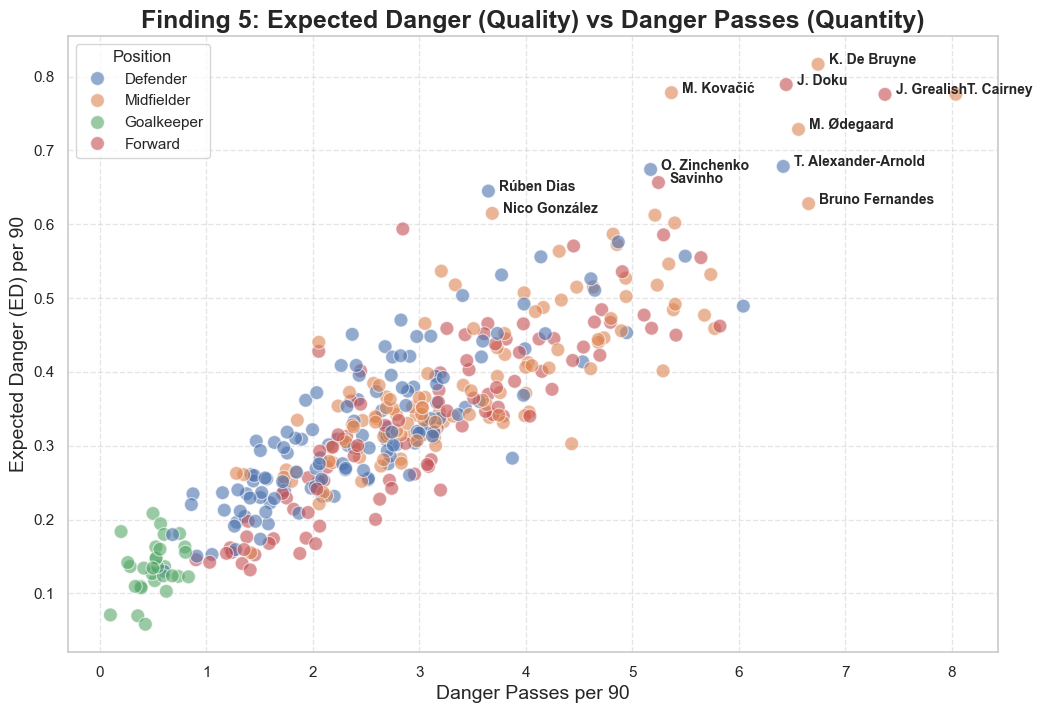

In [27]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=final[final['minutes'] > 500], x='dp_per_90', y='ed_per_90', alpha=0.6, hue='role', s=100)

# Label top 10 unique players to demonstrate findings
top_label = final[final['minutes'] > 500].sort_values('ed_per_90', ascending=False).head(12)
for _, row in top_label.iterrows():
    plt.text(row['dp_per_90']+0.1, row['ed_per_90'], row['short_name'], fontsize=10, fontweight='bold')

plt.title("Finding 5: Expected Danger (Quality) vs Danger Passes (Quantity)", fontsize=18, fontweight='bold')
plt.xlabel("Danger Passes per 90", fontsize=14)
plt.ylabel("Expected Danger (ED) per 90", fontsize=14)
plt.legend(title='Position')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## Visualizations

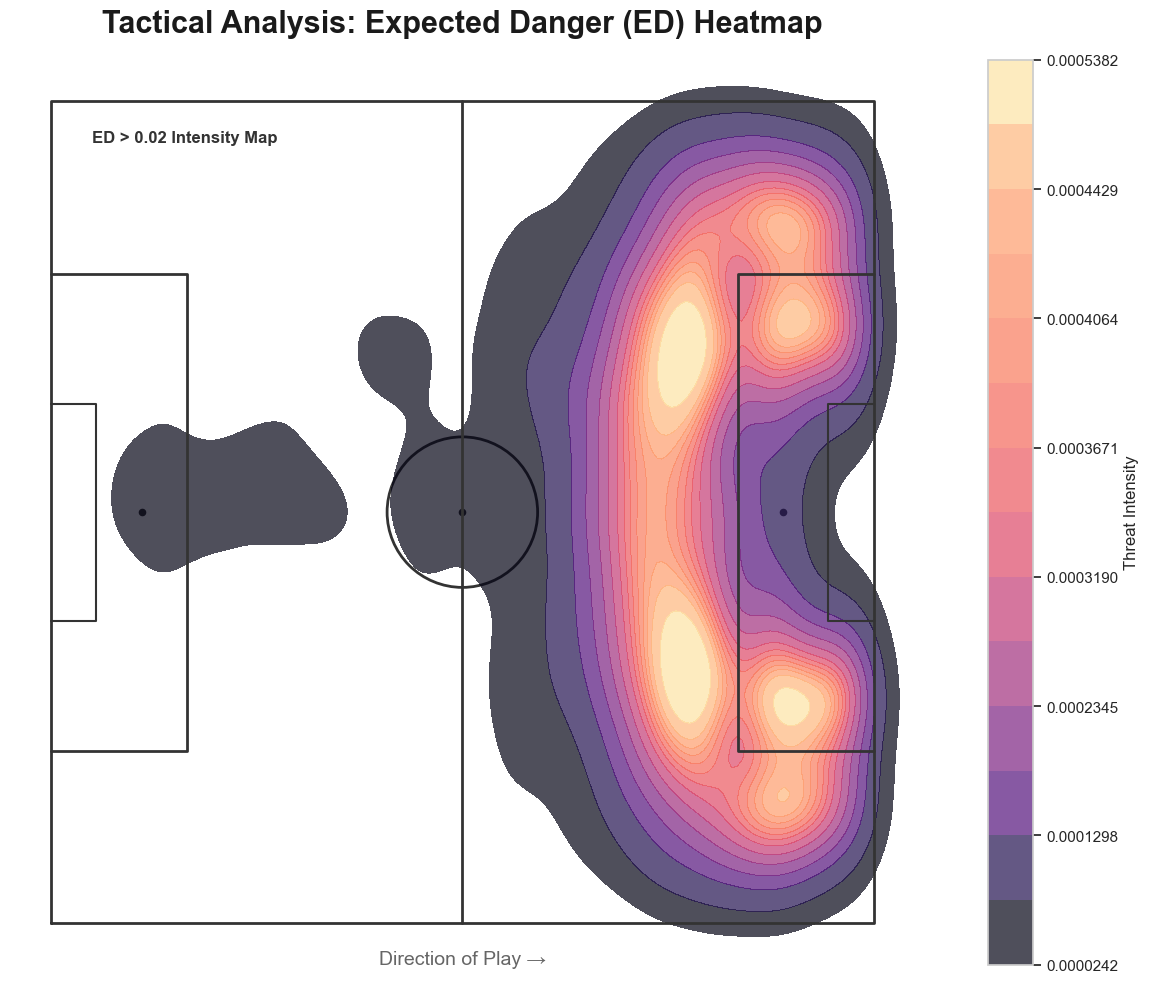

In [ ]:
def draw_pitch(ax, pitch_color='#ffffff', line_color='#222222'):


    ax.plot([0, 100, 100, 0, 0], [0, 0, 100, 100, 0], color=line_color, linewidth=2)
    ax.plot([50, 50], [0, 100], color=line_color, linewidth=2)
    
    ax.plot([0, 16.5, 16.5, 0], [21, 21, 79, 79], color=line_color, linewidth=2)
    ax.plot([100, 83.5, 83.5, 100], [21, 21, 79, 79], color=line_color, linewidth=2)
    
    ax.plot([0, 5.5, 5.5, 0], [36.8, 36.8, 63.2, 63.2], color=line_color, linewidth=1.5)
    ax.plot([100, 94.5, 94.5, 100], [36.8, 36.8, 63.2, 63.2], color=line_color, linewidth=1.5)
    
    centre_circle = plt.Circle((50, 50), 9.15, color=line_color, fill=False, linewidth=2)
    ax.add_patch(centre_circle)
    ax.scatter([50, 11, 89], [50, 50, 50], color=line_color, s=20)
    
    ax.set_facecolor(pitch_color)
    ax.set_xlim(-5, 105)
    ax.set_ylim(-5, 105)
    ax.set_aspect('equal')
    ax.axis('off')

plt.figure(figsize=(15, 10))
ax = plt.gca()

draw_pitch(ax, pitch_color='#f0f0f0', line_color='#333333')

high_danger = df_model[df_model['expected_danger'] > 0.02] # Lower threshold for more detail

kde = sns.kdeplot(
    x=high_danger['x'], 
    y=high_danger['y'], 
    fill=True, 
    alpha=0.7, 
    cmap='magma', 
    levels=15, 
    ax=ax, 
    cbar=True,
    cbar_kws={'label': 'Threat Intensity'}
)

plt.title("Tactical Analysis: Expected Danger (ED) Heatmap", fontsize=22, fontweight='bold', pad=20, color='#1a1a1a')
plt.text(50, -5, "Direction of Play →", ha='center', fontsize=14, color='#666666')
plt.text(5, 95, "ED > 0.02 Intensity Map", fontsize=12, color='#333333', fontweight='700')

plt.tight_layout()
plt.show()